In [11]:
# %%
# Import libraries
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import argparse
import mlflow
from torch.nn import DataParallel

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    RandFlipd,
    RandShiftIntensityd,
    ScaleIntensityd,
    SpatialPadd,
    RandSpatialCropSamplesd,
    LambdaD,
    ConcatItemsd,
    RandRotate90d,
    ToTensord
)
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR
from monai.data import (
    DataLoader,
    CacheDataset,
    decollate_batch,
)

In [12]:

def create_multichannel_datalist(image_filenames, label_filenames, stack_size=5):
    datalist = []
    end = len(image_filenames) - stack_size + 1
    start = 0
    while start <= end:
        img_dict = {}
        for j in range(stack_size):
            img_dict[f"image{j}"] = str(image_filenames[start + j])
        for j in range(stack_size):
            img_dict[f"label{j}"] = str(label_filenames[start + j])
        datalist.append(img_dict)
        start += stack_size
    return datalist
# Train location
train_dir = "/home/erattakulangara/hpchome/DeepLearningAlgo/2024-SSLUnetR/Data/VoiceUsers/Train/user2"
val_dir = train_dir
# Gather training and validation image paths
train_nrrd_files = sorted([
    os.path.join(train_dir, f) for f in os.listdir(train_dir) 
    if f.endswith(".nrrd") and not f.endswith(".seg.nrrd")
])
train_seg_nrrd_files = sorted([
    os.path.join(train_dir, f) for f in os.listdir(train_dir) 
    if f.endswith(".seg.nrrd")
])

val_nrrd_files = sorted([
    os.path.join(val_dir, f) for f in os.listdir(val_dir) 
    if f.endswith(".nrrd") and not f.endswith(".seg.nrrd")
])
val_seg_nrrd_files = sorted([
    os.path.join(val_dir, f) for f in os.listdir(val_dir) 
    if f.endswith(".seg.nrrd")
])

# Create data lists for training and validation
train_datalist = create_multichannel_datalist(train_nrrd_files, train_seg_nrrd_files)
validation_datalist = create_multichannel_datalist(train_nrrd_files[:5], train_seg_nrrd_files[:5])
print(f"Training datalist setup: {train_datalist[0]}")

Training datalist setup: {'image0': '/home/erattakulangara/hpchome/DeepLearningAlgo/2024-SSLUnetR/Data/VoiceUsers/Train/user2/4 3DGRE_A FATHER 3D.nrrd', 'image1': '/home/erattakulangara/hpchome/DeepLearningAlgo/2024-SSLUnetR/Data/VoiceUsers/Train/user2/5 3DGRE_I FEET 3D.nrrd', 'image2': '/home/erattakulangara/hpchome/DeepLearningAlgo/2024-SSLUnetR/Data/VoiceUsers/Train/user2/6 3DGRE_E HEAD.nrrd', 'image3': '/home/erattakulangara/hpchome/DeepLearningAlgo/2024-SSLUnetR/Data/VoiceUsers/Train/user2/7 3DGRE_o NO.nrrd', 'image4': '/home/erattakulangara/hpchome/DeepLearningAlgo/2024-SSLUnetR/Data/VoiceUsers/Train/user2/8 3DGRE_u FOOD.nrrd', 'label0': '/home/erattakulangara/hpchome/DeepLearningAlgo/2024-SSLUnetR/Data/VoiceUsers/Train/user2/4 3DGRE_A FATHER 3D.seg.nrrd', 'label1': '/home/erattakulangara/hpchome/DeepLearningAlgo/2024-SSLUnetR/Data/VoiceUsers/Train/user2/5 3DGRE_I FEET 3D.seg.nrrd', 'label2': '/home/erattakulangara/hpchome/DeepLearningAlgo/2024-SSLUnetR/Data/VoiceUsers/Train/user

In [35]:
# %%
# Define transforms for training and validation

def binarize_label(label):
    # Binarize the label: convert to 1 if > 0, else 0
    return (label > 0).astype(label.dtype)

def threshold_image(image):
    # Threshold the image: set values below 0.08 to 0
    return np.where(image < 0.08, 0, image)

# Training transforms
train_transforms = Compose([
    LoadImaged(keys=["image0", "image1", "image2", "image3", "image4", "label0","label1","label2","label3","label4"]),
    EnsureChannelFirstd(keys=["image0", "image1", "image2", "image3", "image4", "label0","label1","label2","label3","label4"]),
    ConcatItemsd(keys=["image0", "image1", "image2", "image3", "image4"], name="image"),
    ConcatItemsd(keys=["label0","label1","label2","label3","label4"], name="label"),
    ScaleIntensityd(keys=["image"], minv=0, maxv=1),
    LambdaD(keys="label", func=binarize_label),
    LambdaD(keys="image", func=threshold_image),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    SpatialPadd(keys=["image", "label"], spatial_size=(64, 64, 64)),
    RandSpatialCropSamplesd(keys=["image", "label"], roi_size=(64, 64, 64), random_size=False, num_samples=2),
    RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
    RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
    RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),
    RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),
    RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
    ToTensord(keys=["image", "label"]),
])

# Validation transforms
val_transforms = Compose([
    LoadImaged(keys=["image0", "image1", "image2", "image3", "image4", "label0", "label1", "label2", "label3", "label4"]),
    EnsureChannelFirstd(keys=["image0", "image1", "image2", "image3", "image4", "label0", "label1", "label2", "label3", "label4"]),
    ConcatItemsd(keys=["image0", "image1", "image2", "image3", "image4"], name="image"),
    ConcatItemsd(keys=["label0", "label1", "label2", "label3", "label4"], name="label"),
    ScaleIntensityd(keys=["image"], minv=0, maxv=1),
    LambdaD(keys="label", func=binarize_label),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    SpatialPadd(keys=["image", "label"], spatial_size=(64, 64, 64)),
    ToTensord(keys=["image", "label"]),
])

/home/erattakulangara/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [36]:
# Create DataLoaders for training and validation

train_ds = CacheDataset(data=train_datalist, transform=train_transforms,
                        cache_num=24, cache_rate=1.0, num_workers=2)


# Create DataLoader for training with the specified parameters
train_loader = DataLoader(train_ds, batch_size=4,
                          shuffle=True, num_workers=4, pin_memory=True)

val_ds = CacheDataset(data=validation_datalist, transform=val_transforms,
                      cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1,
                        shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


dict_keys(['image0', 'image1', 'image2', 'image3', 'image4', 'label0', 'label1', 'label2', 'label3', 'label4', 'image', 'label', 'foreground_start_coord', 'foreground_end_coord'])
torch.Size([2, 5, 64, 64, 64])


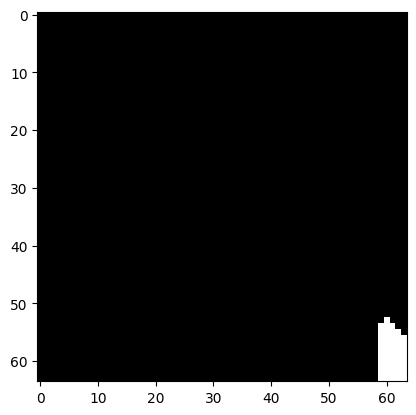

In [39]:
#visualizing the dataset

import matplotlib.pyplot as plt

for sample in train_loader:
    
    if isinstance(sample, dict):
        print(sample.keys())
        print(sample['image'].shape)
        plt.imshow(sample['label'][0,0,:,:,30], cmap="grey")